# MSE et Linear

In [ ]:
# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate
 
import torch
import numpy as np
from torch.autograd import Function
from torch.autograd import gradcheck
import matplotlib.pyplot as plt
 
 
class Context:
    """Un objet contexte très simplifié pour simuler PyTorch
 
    Un contexte différent doit être utilisé à chaque forward
    """
    def __init__(self):
        self._saved_tensors = ()
    def save_for_backward(self, *args):
        self._saved_tensors = args
    @property
    def saved_tensors(self):
        return self._saved_tensors
 
 
class MSE(Function):
    """Début d'implementation de la fonction MSE"""
    @staticmethod
    def forward(ctx, yhat, y):
        ## Garde les valeurs nécessaires pour le backwards
        ctx.save_for_backward(yhat, y)
        q = yhat.shape[0]
        return (1/q) * ((yhat-y)**2).sum()
        #  TODO:  Renvoyer la valeur de la fonction
 
    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        yhat, y = ctx.saved_tensors
        q = yhat.shape[0]
        dyhat = grad_output* 2/q * (yhat - y)
        dy = -dyhat
        return dyhat,dy
        #  TODO:  Renvoyer par les deux dérivées partielles (par rapport à yhat et à y)
 
#  TODO:  Implémenter la fonction Linear(X, W, b)
class Linear(Function):
    """Début d'implementation de la fonction Linear"""
    @staticmethod
    def forward(ctx, X, W, b):
        ## Garde les valeurs nécessaires pour le backwards
        ctx.save_for_backward(X, W)
        return torch.mm(X,W)+b
        #  TODO:  Renvoyer la valeur de la fonction
 
    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        X, W = ctx.saved_tensors
        q = y.shape[0]
        grad_yhat=grad_output
        dw = torch.matmul(X.T,grad_yhat)
        db = grad_yhat
        dx = torch.matmul(grad_yhat,W.T)
 
        return dx, dw, db
 
mse = MSE.apply
linear = Linear.apply
 
print(mse)
print(linear)

<built-in method apply of FunctionMeta object at 0x536b698>
<built-in method apply of FunctionMeta object at 0x536ba58>


In [ ]:
yhat = torch.randn(1,5, requires_grad=True, dtype=torch.float64)
y = torch.randn(1,5, requires_grad=True, dtype=torch.float64)
torch.autograd.gradcheck(mse, (yhat, y))

True

In [ ]:
X = torch.randn(10,4, requires_grad=True, dtype=torch.float64)
W = torch.randn(4,12, requires_grad=True, dtype=torch.float64)
b = torch.randn(1,12, requires_grad=True, dtype=torch.float64)
torch.autograd.gradcheck(linear, (X, W, b))

True

# Descente de gradient

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# Les données supervisées
X = torch.randn(50, 13)
y = torch.randn(50, 3)

def gradient_descent(X,y,epsilon,maxiter=100,verbose=True):
    # Les paramètres du modèle à optimiser
    w = torch.randn(X.shape[1], y.shape[1])
    b = torch.randn(y.shape[1])
    ctxMSE = Context()
    ctxLinear = Context()
    writer = SummaryWriter()
    arrayError = []
    for n_iter in range(maxiter):
        yhat = Linear.forward(ctxLinear,X,w,b)
        loss = MSE.forward(ctxMSE,yhat,y)
        if (n_iter % 20 == 0):
          print(f"Itérations {n_iter}: loss {loss}")
          pass
        writer.add_scalar('Loss/train', loss, n_iter)
        # Sortie directe
        grad_output = MSE.backward(ctxMSE,1)[0]
        ##  TODO:  Calcul du backward (grad_w, grad_b)
        dx, dw, db = Linear.backward(ctxLinear, grad_output)
        ##  TODO:  Mise à jour des paramètres du modèle
        w = w - epsilon*dw
        b = b - epsilon*db
        arrayError.append(loss)
    if verbose:
        plt.plot([i for i in range(maxiter)],arrayError)
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Loss")
        plt.title("Descente de gradient")
        plt.savefig("tme1")
        plt.show()
    return arrayError

Itérations 0: loss 312.7992858886719
Itérations 20: loss 240.06724548339844
Itérations 40: loss 191.43516540527344
Itérations 60: loss 158.91204833984375
Itérations 80: loss 137.15830993652344
Itérations 0: loss 274.94757080078125
Itérations 20: loss 84.99333953857422
Itérations 40: loss 82.10994720458984
Itérations 60: loss 82.00151824951172
Itérations 80: loss 81.93526458740234
Itérations 0: loss 322.6455383300781
Itérations 20: loss 114.77788543701172
Itérations 40: loss 114.5657958984375
Itérations 60: loss 114.38262176513672
Itérations 80: loss 114.19976043701172


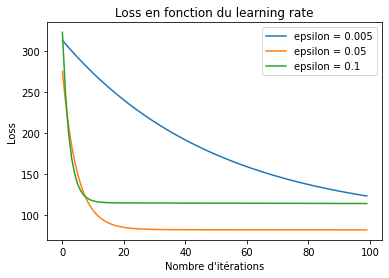

In [ ]:
X = torch.randn(5000, 4)
y = torch.randn(5000, 50)
maxiter = 100
arrayEpsilon = [0.005,0.05,0.1]
errors = []
for epsilon in arrayEpsilon:
    error = gradient_descent(X,y,epsilon,maxiter,verbose=False)
    plt.plot([i for i in range(maxiter)],error,label="epsilon = {}".format(epsilon))
plt.xlabel("Nombre d'itérations")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss en fonction du learning rate")
plt.savefig("tme1")
plt.show()